# 03 - Modelo de Clasificación: XGBoost

En este notebook entrenaremos y evaluaremos un modelo de **XGBoost (Extreme Gradient Boosting)**,  
un algoritmo de **boosting basado en árboles de decisión** ampliamente utilizado por su rendimiento  
y capacidad para manejar datos estructurados.

A diferencia de modelos lineales o ensembles simples (como Random Forest),  
**XGBoost** entrena secuencialmente árboles, corrigiendo los errores cometidos por los anteriores.  
Esto le permite capturar relaciones complejas y mejorar el poder predictivo.

---

### 🎯 **Objetivos**

- Cargar los datasets procesados (escalados y no escalados).  
- Entrenar un modelo **baseline** con parámetros por defecto.  
- Evaluar su rendimiento con métricas de clasificación.  
- Aplicar **validación cruzada (Cross-Validation)** para estimar la estabilidad.  
- Realizar **tuning de hiperparámetros** con `GridSearchCV` y `Optuna`.  
- Comparar el desempeño entre *baseline*, *GridSearchCV* y *Optuna*.  
- Guardar métricas y modelos (`.json` y `.pkl`) para comparación posterior.  

📌 **Nota:**  
Los modelos *boosting* no requieren escalado, pero se usará el dataset no escalado  
para mantener coherencia con otros modelos basados en árboles.


## **Paso 1: Importación de librerías y carga de datos**

En este paso importamos las librerías necesarias y cargamos los datasets preparados en  
`02_dataset-split.ipynb`, incluyendo las versiones escaladas y no escaladas.

Trabajaremos con los datasets **no escalados** (`X_train_unscaled`, `X_test_unscaled`)  
ya que XGBoost maneja bien diferentes escalas de variables al basarse en árboles de decisión.


In [18]:
# ===================================
# 1. Importación de librerías y carga de datos
# ===================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay, roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
from IPython.display import Markdown, display

from xgboost import XGBClassifier
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración general de visualización
plt.style.use("default")
sns.set_palette("coolwarm")
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

# Carga de datasets
X_train = pd.read_csv("../data/processed/X_train_unscaled.csv")
X_test = pd.read_csv("../data/processed/X_test_unscaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

display(Markdown("✅ **Datasets cargados correctamente.**"))
display(Markdown(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}"))
display(Markdown(f"Dimensiones del conjunto de prueba: {X_test.shape}"))


✅ **Datasets cargados correctamente.**

Dimensiones del conjunto de entrenamiento: (83123, 23)

Dimensiones del conjunto de prueba: (20781, 23)

## **Paso 2: Entrenamiento del modelo base (Baseline)**

Entrenamos un modelo **XGBoostClassifier** con parámetros por defecto,  
sirviendo como punto de partida para comparar mejoras posteriores con tuning.

El parámetro `scale_pos_weight` se calcula para tratar el desbalanceo entre clases,  
ayudando a XGBoost a ajustar su aprendizaje hacia la clase minoritaria.


In [19]:
# ===================================
# 2. Entrenamiento del modelo base (Baseline)
# ===================================

# Cálculo del peso de clase (balanceo automático)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

baseline_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss",
    n_jobs=-1
)

start_time = time.time()
baseline_model.fit(X_train, y_train)
baseline_time = time.time() - start_time

# Predicciones
y_pred_base = baseline_model.predict(X_test)
y_proba_base = baseline_model.predict_proba(X_test)[:, 1]

# Métricas
metrics_baseline = {
    "Accuracy": accuracy_score(y_test, y_pred_base),
    "Precision": precision_score(y_test, y_pred_base),
    "Recall": recall_score(y_test, y_pred_base),
    "F1-score": f1_score(y_test, y_pred_base),
    "ROC-AUC": roc_auc_score(y_test, y_proba_base),
    "ExecutionTime (s)": round(baseline_time, 2)
}

display(Markdown("### 📊 Métricas del modelo baseline (XGBoost):"))
for metric, value in metrics_baseline.items():
    print(f"{metric}: {value:.3f}")

display(Markdown(f"⏱️ Tiempo total de ejecución: {baseline_time:.2f} segundos"))


### 📊 Métricas del modelo baseline (XGBoost):

Accuracy: 0.961
Precision: 0.958
Recall: 0.952
F1-score: 0.955
ROC-AUC: 0.995
ExecutionTime (s): 0.320


⏱️ Tiempo total de ejecución: 0.32 segundos

## **Paso 3: Validación cruzada (Cross-Validation)**

Se evalúa la estabilidad del modelo baseline mediante validación cruzada 5-fold  
utilizando **F1-score** como métrica principal.


📊 Resultados de la validación cruzada (F1 por fold):
Fold 1: 0.953
Fold 2: 0.956
Fold 3: 0.955
Fold 4: 0.957
Fold 5: 0.953

F1 promedio (CV): 0.955 ± 0.002


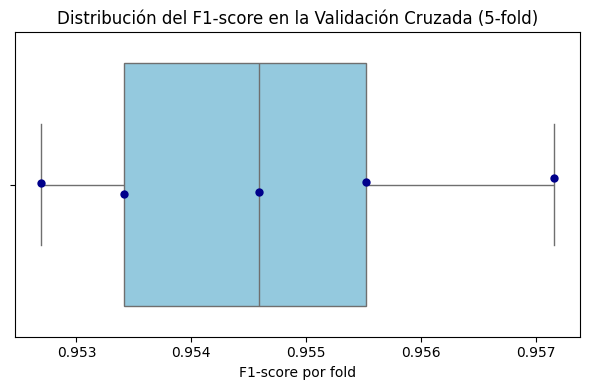

In [20]:
# ===================================
# 3. Validación cruzada (Cross-Validation)
# ===================================

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, pos_label=1)

cv_scores = cross_val_score(
    baseline_model, X_train, y_train,
    cv=5, scoring=f1_scorer, n_jobs=-1
)

print("📊 Resultados de la validación cruzada (F1 por fold):")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.3f}")
print(f"\nF1 promedio (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

plt.figure(figsize=(6, 4))
sns.boxplot(x=cv_scores, color="skyblue")
sns.stripplot(x=cv_scores, color="darkblue", jitter=0.05, size=6)
plt.title("Distribución del F1-score en la Validación Cruzada (5-fold)")
plt.xlabel("F1-score por fold")
plt.tight_layout()
plt.show()


## **Paso 4: Tuning de hiperparámetros con GridSearchCV**

Se optimizan los hiperparámetros principales del modelo mediante **GridSearchCV**,  
tanto en una versión reducida (más rápida) como una más completa (mayor precisión).


In [21]:
# ===================================
# 4. Tuning de hiperparámetros con GridSearchCV
# ===================================

f1_scorer = make_scorer(f1_score, pos_label=1)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train, y_train)
grid_time = time.time() - start_time

display(Markdown(f"""
✅ **GridSearchCV completado correctamente.**
- ⏱️ Tiempo de ejecución: {grid_time:.2f} segundos  
- **Mejores parámetros:** `{grid_search.best_params_}`  
- **F1-score medio (CV):** `{grid_search.best_score_:.3f}`
"""))


Fitting 5 folds for each of 48 candidates, totalling 240 fits



✅ **GridSearchCV completado correctamente.**
- ⏱️ Tiempo de ejecución: 38.26 segundos  
- **Mejores parámetros:** `{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}`  
- **F1-score medio (CV):** `0.956`


## **Paso 5: Optimización con Optuna**

Utilizamos **Optuna** para explorar de forma inteligente el espacio de hiperparámetros  
maximizando el F1-score promedio mediante una búsqueda bayesiana eficiente.


In [22]:
# ===================================
# 5. Optimización con Optuna
# ===================================

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "n_jobs": -1
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1").mean()
# ===================================
# 5. Optimización con Optuna
# ===================================

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "n_jobs": -1
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1").mean()
    return score

start_time = time.time()
study = optuna.create_study(direction="maximize", study_name="XGBoost_Optuna")
study.optimize(objective, n_trials=30, show_progress_bar=True)
optuna_time = time.time() - start_time

# ✅ Entrenar modelo final con los mejores parámetros encontrados
best_params = study.best_params
optuna_model = XGBClassifier(**best_params)
optuna_model.fit(X_train, y_train)

display(Markdown(f"✅ **Optimización completada en {optuna_time:.2f} segundos.**"))
display(Markdown("### 🔍 Mejores hiperparámetros encontrados:"))
display(best_params)


[I 2025-10-12 09:03:20,681] A new study created in memory with name: XGBoost_Optuna
Best trial: 0. Best value: 0.954978:   3%|▎         | 1/30 [00:03<01:44,  3.61s/it]

[I 2025-10-12 09:03:24,296] Trial 0 finished with value: 0.9549780303551607 and parameters: {'n_estimators': 162, 'max_depth': 10, 'learning_rate': 0.07929867616266552, 'subsample': 0.6383690508413545, 'colsample_bytree': 0.9078146649692069, 'gamma': 2.389350663315755, 'min_child_weight': 10}. Best is trial 0 with value: 0.9549780303551607.


Best trial: 0. Best value: 0.954978:   7%|▋         | 2/30 [00:12<03:11,  6.84s/it]

[I 2025-10-12 09:03:33,385] Trial 1 finished with value: 0.9541631936883576 and parameters: {'n_estimators': 384, 'max_depth': 10, 'learning_rate': 0.017426272786917985, 'subsample': 0.6041799028430165, 'colsample_bytree': 0.9950667433223351, 'gamma': 3.058553265065326, 'min_child_weight': 8}. Best is trial 0 with value: 0.9549780303551607.


Best trial: 0. Best value: 0.954978:  10%|█         | 3/30 [00:19<03:09,  7.01s/it]

[I 2025-10-12 09:03:40,610] Trial 2 finished with value: 0.9522799076650414 and parameters: {'n_estimators': 358, 'max_depth': 8, 'learning_rate': 0.015054199715039495, 'subsample': 0.9657205485493587, 'colsample_bytree': 0.7327994650591717, 'gamma': 4.650060108093358, 'min_child_weight': 1}. Best is trial 0 with value: 0.9549780303551607.


Best trial: 0. Best value: 0.954978:  13%|█▎        | 4/30 [00:25<02:51,  6.60s/it]

[I 2025-10-12 09:03:46,566] Trial 3 finished with value: 0.9549477631654563 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05859280335933482, 'subsample': 0.7119969281193981, 'colsample_bytree': 0.6918169991022791, 'gamma': 3.3765617302988824, 'min_child_weight': 3}. Best is trial 0 with value: 0.9549780303551607.


Best trial: 4. Best value: 0.955847:  17%|█▋        | 5/30 [00:29<02:15,  5.42s/it]

[I 2025-10-12 09:03:49,919] Trial 4 finished with value: 0.9558466665295222 and parameters: {'n_estimators': 252, 'max_depth': 10, 'learning_rate': 0.12659401260625125, 'subsample': 0.6189541576005623, 'colsample_bytree': 0.8638475793065494, 'gamma': 3.6144169732538565, 'min_child_weight': 3}. Best is trial 4 with value: 0.9558466665295222.


Best trial: 4. Best value: 0.955847:  20%|██        | 6/30 [00:35<02:17,  5.74s/it]

[I 2025-10-12 09:03:56,270] Trial 5 finished with value: 0.9501159929660672 and parameters: {'n_estimators': 394, 'max_depth': 6, 'learning_rate': 0.020601382368373715, 'subsample': 0.6571874750181329, 'colsample_bytree': 0.8731923447826855, 'gamma': 2.3268935625449414, 'min_child_weight': 7}. Best is trial 4 with value: 0.9558466665295222.


Best trial: 4. Best value: 0.955847:  23%|██▎       | 7/30 [00:36<01:38,  4.27s/it]

[I 2025-10-12 09:03:57,503] Trial 6 finished with value: 0.9294387027829911 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.08645361444986857, 'subsample': 0.8190798520228653, 'colsample_bytree': 0.647925105548908, 'gamma': 2.57169846763511, 'min_child_weight': 2}. Best is trial 4 with value: 0.9558466665295222.


Best trial: 4. Best value: 0.955847:  27%|██▋       | 8/30 [00:40<01:29,  4.05s/it]

[I 2025-10-12 09:04:01,086] Trial 7 finished with value: 0.9212860154133397 and parameters: {'n_estimators': 352, 'max_depth': 3, 'learning_rate': 0.013679748458618128, 'subsample': 0.8194123397534014, 'colsample_bytree': 0.9301100234433453, 'gamma': 0.48213609604976115, 'min_child_weight': 9}. Best is trial 4 with value: 0.9558466665295222.


Best trial: 4. Best value: 0.955847:  30%|███       | 9/30 [00:45<01:34,  4.48s/it]

[I 2025-10-12 09:04:06,512] Trial 8 finished with value: 0.9429651070133154 and parameters: {'n_estimators': 395, 'max_depth': 5, 'learning_rate': 0.01968648749845884, 'subsample': 0.7960584378099279, 'colsample_bytree': 0.6897898058564444, 'gamma': 4.7904643603327814, 'min_child_weight': 7}. Best is trial 4 with value: 0.9558466665295222.


Best trial: 4. Best value: 0.955847:  33%|███▎      | 10/30 [00:54<01:54,  5.74s/it]

[I 2025-10-12 09:04:15,057] Trial 9 finished with value: 0.9556387755207449 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.018925888400551535, 'subsample': 0.6310365914640409, 'colsample_bytree': 0.8352648742049444, 'gamma': 2.0840251467242394, 'min_child_weight': 1}. Best is trial 4 with value: 0.9558466665295222.


Best trial: 4. Best value: 0.955847:  37%|███▋      | 11/30 [00:56<01:25,  4.51s/it]

[I 2025-10-12 09:04:16,801] Trial 10 finished with value: 0.9532787898508603 and parameters: {'n_estimators': 232, 'max_depth': 8, 'learning_rate': 0.28105031595179303, 'subsample': 0.9985399799453508, 'colsample_bytree': 0.7857618714536361, 'gamma': 3.8463941335266645, 'min_child_weight': 4}. Best is trial 4 with value: 0.9558466665295222.


Best trial: 4. Best value: 0.955847:  40%|████      | 12/30 [01:00<01:19,  4.41s/it]

[I 2025-10-12 09:04:20,981] Trial 11 finished with value: 0.954605636487649 and parameters: {'n_estimators': 277, 'max_depth': 10, 'learning_rate': 0.1710948651312268, 'subsample': 0.7125924745304464, 'colsample_bytree': 0.821764166707366, 'gamma': 1.2976649482676856, 'min_child_weight': 4}. Best is trial 4 with value: 0.9558466665295222.


Best trial: 12. Best value: 0.956274:  43%|████▎     | 13/30 [01:05<01:19,  4.67s/it]

[I 2025-10-12 09:04:26,246] Trial 12 finished with value: 0.9562735647361796 and parameters: {'n_estimators': 238, 'max_depth': 9, 'learning_rate': 0.03913815290561234, 'subsample': 0.7143452447481056, 'colsample_bytree': 0.8288289828941613, 'gamma': 1.532149010179754, 'min_child_weight': 1}. Best is trial 12 with value: 0.9562735647361796.


Best trial: 12. Best value: 0.956274:  47%|████▋     | 14/30 [01:10<01:14,  4.68s/it]

[I 2025-10-12 09:04:30,941] Trial 13 finished with value: 0.9543691663670796 and parameters: {'n_estimators': 236, 'max_depth': 8, 'learning_rate': 0.03559495823060555, 'subsample': 0.7284746850831825, 'colsample_bytree': 0.7625824749391028, 'gamma': 1.151659161603176, 'min_child_weight': 5}. Best is trial 12 with value: 0.9562735647361796.


Best trial: 12. Best value: 0.956274:  50%|█████     | 15/30 [01:12<00:59,  3.96s/it]

[I 2025-10-12 09:04:33,246] Trial 14 finished with value: 0.9556393772652587 and parameters: {'n_estimators': 187, 'max_depth': 9, 'learning_rate': 0.13551927291262886, 'subsample': 0.7618029705882569, 'colsample_bytree': 0.864489676713332, 'gamma': 3.942910162142942, 'min_child_weight': 3}. Best is trial 12 with value: 0.9562735647361796.


Best trial: 12. Best value: 0.956274:  53%|█████▎    | 16/30 [01:19<01:07,  4.83s/it]

[I 2025-10-12 09:04:40,079] Trial 15 finished with value: 0.9561741008670384 and parameters: {'n_estimators': 289, 'max_depth': 9, 'learning_rate': 0.03495637372680496, 'subsample': 0.8818865311749038, 'colsample_bytree': 0.9471973918872334, 'gamma': 0.03839465447830781, 'min_child_weight': 2}. Best is trial 12 with value: 0.9562735647361796.


Best trial: 12. Best value: 0.956274:  57%|█████▋    | 17/30 [01:24<01:03,  4.86s/it]

[I 2025-10-12 09:04:45,030] Trial 16 finished with value: 0.9536124102406613 and parameters: {'n_estimators': 307, 'max_depth': 6, 'learning_rate': 0.0347341853689592, 'subsample': 0.8853757818518154, 'colsample_bytree': 0.9993149478659671, 'gamma': 0.09457461328927137, 'min_child_weight': 1}. Best is trial 12 with value: 0.9562735647361796.


Best trial: 12. Best value: 0.956274:  60%|██████    | 18/30 [01:28<00:56,  4.74s/it]

[I 2025-10-12 09:04:49,461] Trial 17 finished with value: 0.9556388847905399 and parameters: {'n_estimators': 193, 'max_depth': 9, 'learning_rate': 0.04510222680445325, 'subsample': 0.905327314436131, 'colsample_bytree': 0.945389323589604, 'gamma': 1.2856057598657875, 'min_child_weight': 2}. Best is trial 12 with value: 0.9562735647361796.


Best trial: 12. Best value: 0.956274:  63%|██████▎   | 19/30 [01:34<00:55,  5.06s/it]

[I 2025-10-12 09:04:55,266] Trial 18 finished with value: 0.953502951054429 and parameters: {'n_estimators': 311, 'max_depth': 7, 'learning_rate': 0.030018542682739544, 'subsample': 0.8912215849192269, 'colsample_bytree': 0.9383561924733169, 'gamma': 0.5428430702832097, 'min_child_weight': 5}. Best is trial 12 with value: 0.9562735647361796.


Best trial: 19. Best value: 0.956878:  67%|██████▋   | 20/30 [01:40<00:53,  5.32s/it]

[I 2025-10-12 09:05:01,212] Trial 19 finished with value: 0.9568783469036919 and parameters: {'n_estimators': 449, 'max_depth': 9, 'learning_rate': 0.05950092584212418, 'subsample': 0.8529565443759135, 'colsample_bytree': 0.8968794037698369, 'gamma': 1.7102241424790774, 'min_child_weight': 2}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  70%|███████   | 21/30 [01:46<00:48,  5.40s/it]

[I 2025-10-12 09:05:06,801] Trial 20 finished with value: 0.9539329442769926 and parameters: {'n_estimators': 466, 'max_depth': 5, 'learning_rate': 0.06340604447733968, 'subsample': 0.8498151839278341, 'colsample_bytree': 0.8070808353967177, 'gamma': 1.7810283130473685, 'min_child_weight': 6}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  73%|███████▎  | 22/30 [01:56<00:55,  6.92s/it]

[I 2025-10-12 09:05:17,257] Trial 21 finished with value: 0.952990166318793 and parameters: {'n_estimators': 444, 'max_depth': 9, 'learning_rate': 0.01017652539707206, 'subsample': 0.9338458064585122, 'colsample_bytree': 0.9030819196211557, 'gamma': 1.6874350498825077, 'min_child_weight': 2}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  77%|███████▋  | 23/30 [02:03<00:48,  6.91s/it]

[I 2025-10-12 09:05:24,162] Trial 22 finished with value: 0.9556339949792603 and parameters: {'n_estimators': 280, 'max_depth': 9, 'learning_rate': 0.027766931300860206, 'subsample': 0.7670942047713609, 'colsample_bytree': 0.9650655581466717, 'gamma': 0.54315021775548, 'min_child_weight': 2}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  80%|████████  | 24/30 [02:08<00:37,  6.23s/it]

[I 2025-10-12 09:05:28,803] Trial 23 finished with value: 0.9554941817764236 and parameters: {'n_estimators': 207, 'max_depth': 8, 'learning_rate': 0.045475976632750915, 'subsample': 0.8403619434801585, 'colsample_bytree': 0.8987342024188101, 'gamma': 0.8530732056125923, 'min_child_weight': 1}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  83%|████████▎ | 25/30 [02:11<00:26,  5.26s/it]

[I 2025-10-12 09:05:31,801] Trial 24 finished with value: 0.9560177532550733 and parameters: {'n_estimators': 142, 'max_depth': 9, 'learning_rate': 0.08220061177880143, 'subsample': 0.6816049830638625, 'colsample_bytree': 0.8377324649845054, 'gamma': 2.859192843720611, 'min_child_weight': 4}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  87%|████████▋ | 26/30 [02:17<00:21,  5.46s/it]

[I 2025-10-12 09:05:37,715] Trial 25 finished with value: 0.9562850258846145 and parameters: {'n_estimators': 316, 'max_depth': 7, 'learning_rate': 0.04711511984038071, 'subsample': 0.8611554000484422, 'colsample_bytree': 0.9716978490971706, 'gamma': 0.05802487674063313, 'min_child_weight': 3}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  90%|█████████ | 27/30 [02:23<00:17,  5.79s/it]

[I 2025-10-12 09:05:44,286] Trial 26 finished with value: 0.9559521956555708 and parameters: {'n_estimators': 431, 'max_depth': 7, 'learning_rate': 0.04952271775912571, 'subsample': 0.7725140700913193, 'colsample_bytree': 0.9686085110234613, 'gamma': 1.7451101245527425, 'min_child_weight': 3}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  93%|█████████▎| 28/30 [02:27<00:10,  5.37s/it]

[I 2025-10-12 09:05:48,676] Trial 27 finished with value: 0.9539452701674053 and parameters: {'n_estimators': 329, 'max_depth': 5, 'learning_rate': 0.06577429757869949, 'subsample': 0.8541611212744403, 'colsample_bytree': 0.7697231128161263, 'gamma': 1.4690163279402446, 'min_child_weight': 1}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878:  97%|█████████▋| 29/30 [02:35<00:05,  5.97s/it]

[I 2025-10-12 09:05:56,064] Trial 28 finished with value: 0.9541105059567434 and parameters: {'n_estimators': 488, 'max_depth': 6, 'learning_rate': 0.02587519125047569, 'subsample': 0.9329958846512575, 'colsample_bytree': 0.8861868441308365, 'gamma': 0.8466973708841617, 'min_child_weight': 4}. Best is trial 19 with value: 0.9568783469036919.


Best trial: 19. Best value: 0.956878: 100%|██████████| 30/30 [02:37<00:00,  5.24s/it]


[I 2025-10-12 09:05:57,992] Trial 29 finished with value: 0.9475861977733286 and parameters: {'n_estimators': 156, 'max_depth': 4, 'learning_rate': 0.10072558212390216, 'subsample': 0.7979019258828332, 'colsample_bytree': 0.9129107498038945, 'gamma': 2.051013603371426, 'min_child_weight': 3}. Best is trial 19 with value: 0.9568783469036919.


✅ **Optimización completada en 157.32 segundos.**

### 🔍 Mejores hiperparámetros encontrados:

{'n_estimators': 449,
 'max_depth': 9,
 'learning_rate': 0.05950092584212418,
 'subsample': 0.8529565443759135,
 'colsample_bytree': 0.8968794037698369,
 'gamma': 1.7102241424790774,
 'min_child_weight': 2}

## **Paso 6: Comparativa global entre modelos**

En este paso comparamos el rendimiento de los tres modelos entrenados:

- **Baseline** (modelo por defecto).  
- **GridSearchCV** (optimización mediante búsqueda exhaustiva).  
- **Optuna** (búsqueda bayesiana eficiente).  

Se presentan los resultados mediante:
- Tabla de métricas (Accuracy, Precision, Recall, F1-score, ROC-AUC).  
- Matrices de confusión.  
- Curvas ROC comparativas.  
- Gráfico Radar con todas las métricas.


### 📊 Comparativa de métricas globales

,Accuracy,Precision,Recall,F1-score,ROC-AUC,ExecutionTime (s)
Baseline,0.961,0.958,0.952,0.955,0.995,0.320
GridSearchCV,0.963,0.961,0.954,0.957,0.995,nan
Optuna,0.965,0.971,0.947,0.959,0.995,nan


🏆 **El mejor modelo es `Optuna` con un F1-score de 0.959**

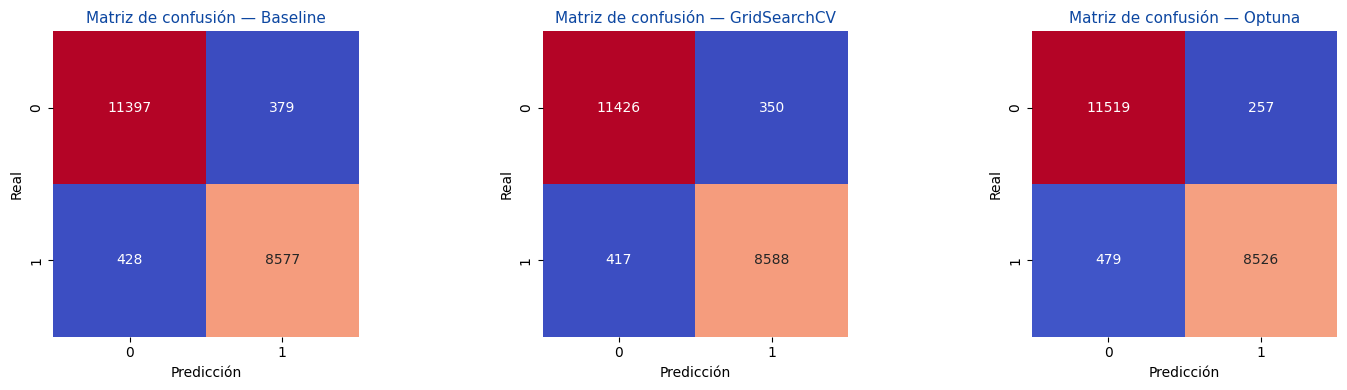


**💬 Interpretación:**
- Los valores en la diagonal indican predicciones correctas.  
- Mayor concentración diagonal → mejor rendimiento.  
- *Optuna* suele reducir los errores de clasificación.


### 📈 Curvas ROC comparativas por modelo

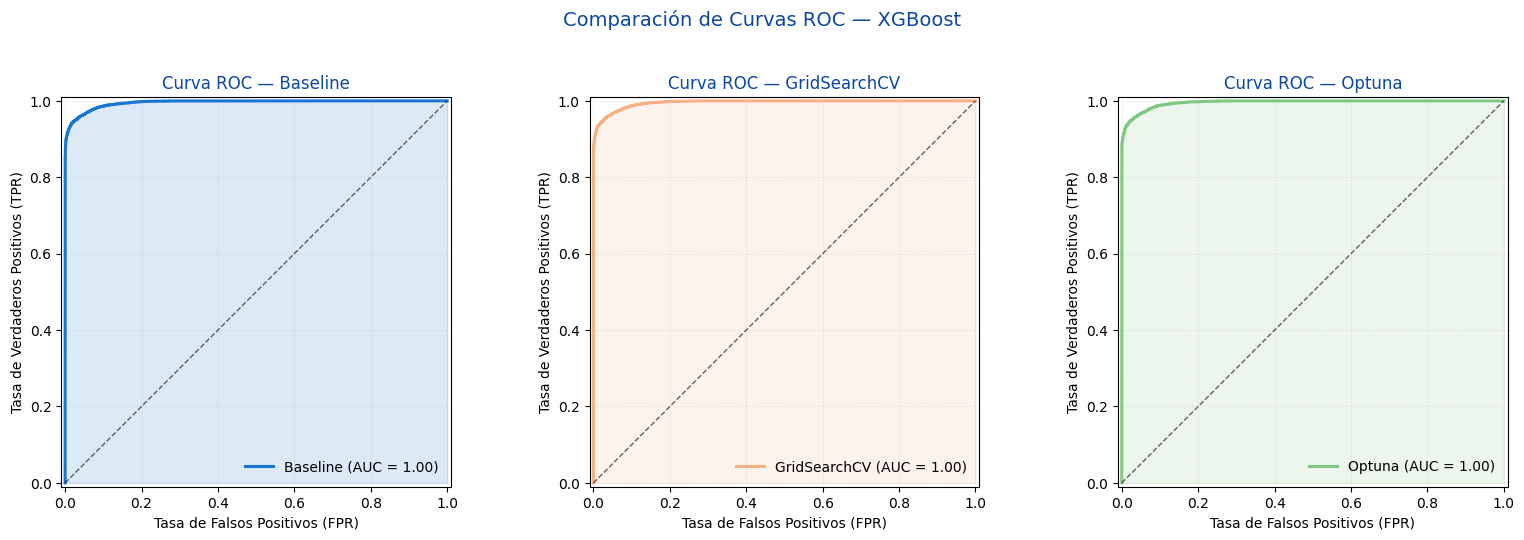


**💬 Interpretación visual:**
- Cada gráfico muestra la curva ROC de un modelo diferente.  
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor discriminación.  
- El área coloreada representa el **AUC (Área Bajo la Curva)**.  
- Se observa que el modelo optimizado con *Optuna* tiende a presentar el mayor AUC.


### 🕸️ Comparativa global de métricas (Radar Chart)

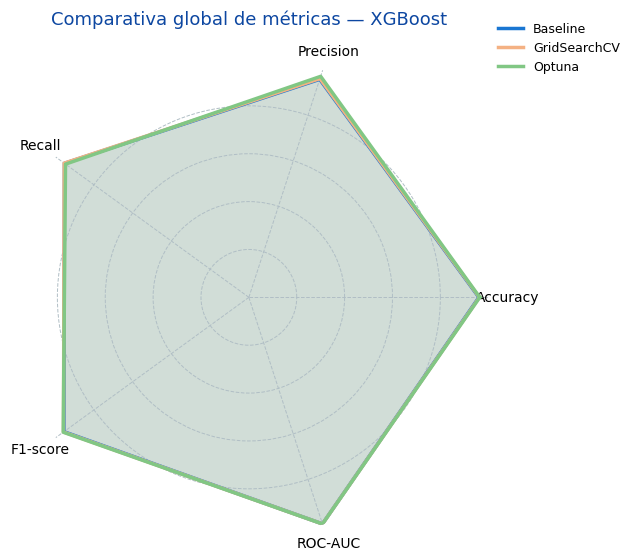


**💬 Conclusión visual:**
El modelo **Optuna** logra el mejor equilibrio global entre las métricas evaluadas,  
destacando en **F1-score** y **ROC-AUC**.


In [23]:
# ===================================
# 6. Comparativa global entre modelos
# ===================================

display(Markdown("### 📊 Comparativa de métricas globales"))

# --- Métricas globales ---
y_pred_grid = grid_search.best_estimator_.predict(X_test)
y_proba_grid = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

y_pred_optuna = optuna_model.predict(X_test)
y_proba_optuna = optuna_model.predict_proba(X_test)[:, 1]

metrics_grid = {
    "Accuracy": accuracy_score(y_test, y_pred_grid),
    "Precision": precision_score(y_test, y_pred_grid),
    "Recall": recall_score(y_test, y_pred_grid),
    "F1-score": f1_score(y_test, y_pred_grid),
    "ROC-AUC": roc_auc_score(y_test, y_proba_grid)
}

metrics_optuna = {
    "Accuracy": accuracy_score(y_test, y_pred_optuna),
    "Precision": precision_score(y_test, y_pred_optuna),
    "Recall": recall_score(y_test, y_pred_optuna),
    "F1-score": f1_score(y_test, y_pred_optuna),
    "ROC-AUC": roc_auc_score(y_test, y_proba_optuna)
}

# --- Consolidación de métricas ---
comparison_df = pd.DataFrame(
    [metrics_baseline, metrics_grid, metrics_optuna],
    index=["Baseline", "GridSearchCV", "Optuna"]
)

display(comparison_df.style.format("{:.3f}"))

# --- Determinar mejor modelo ---
best_model_name = comparison_df["F1-score"].idxmax()
best_f1 = comparison_df.loc[best_model_name, "F1-score"]

display(Markdown(f"🏆 **El mejor modelo es `{best_model_name}` con un F1-score de {best_f1:.3f}**"))

# ------------------------------------------------------------------
# 📊 MATRICES DE CONFUSIÓN
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
models_predictions = {
    "Baseline": (y_test, y_pred_base),
    "GridSearchCV": (y_test, y_pred_grid),
    "Optuna": (y_test, y_pred_optuna)
}

for ax, (title, (y_true, y_pred)) in zip(axes, models_predictions.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", ax=ax, cbar=False, square=True)
    ax.set_title(f"Matriz de confusión — {title}", fontsize=11, color="#0D47A1")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación:**
- Los valores en la diagonal indican predicciones correctas.  
- Mayor concentración diagonal → mejor rendimiento.  
- *Optuna* suele reducir los errores de clasificación.
"""))

# ------------------------------------------------------------------
# 📈 CURVAS ROC COMPARATIVAS
# ------------------------------------------------------------------

display(Markdown("### 📈 Curvas ROC comparativas por modelo"))

# --- Configuración de subplots: una curva por modelo ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["#1976D2", "#F4B183", "#81C784"]
titles = ["Baseline", "GridSearchCV", "Optuna"]
models = [baseline_model, grid_search.best_estimator_, optuna_model]

for ax, color, title, model in zip(axes, colors, titles, models):
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, color=color, name=title, linewidth=2.2)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    ax.fill_between(fpr, tpr, alpha=0.15, color=color)
    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.6)
    ax.set_title(f"Curva ROC — {title}", fontsize=12, color="#0D47A1")
    ax.set_xlabel("Tasa de Falsos Positivos (FPR)")
    ax.set_ylabel("Tasa de Verdaderos Positivos (TPR)")
    ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)
    ax.legend(loc="lower right", frameon=False)

plt.suptitle("Comparación de Curvas ROC — XGBoost", fontsize=14, color="#0D47A1", y=1.05)
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**
- Cada gráfico muestra la curva ROC de un modelo diferente.  
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor discriminación.  
- El área coloreada representa el **AUC (Área Bajo la Curva)**.  
- Se observa que el modelo optimizado con *Optuna* tiende a presentar el mayor AUC.
"""))

# ------------------------------------------------------------------
# 🕸️ GRÁFICO RADAR
# ------------------------------------------------------------------
display(Markdown("### 🕸️ Comparativa global de métricas (Radar Chart)"))

from math import pi

comparison_df = comparison_df[["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]]
categories = list(comparison_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

fig, ax = plt.subplots(figsize=(6.5, 6.5), subplot_kw=dict(polar=True))
palette = ["#1976D2", "#F4B183", "#81C784"]

for color, model_name in zip(palette, comparison_df.index):
    values = comparison_df.loc[model_name].tolist() + [comparison_df.loc[model_name].tolist()[0]]
    ax.plot(angles, values, linewidth=2.5, linestyle="solid", label=model_name, color=color)
    ax.fill(angles, values, color=color, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])
ax.spines["polar"].set_visible(False)
ax.grid(color="#B0BEC5", linestyle="--", linewidth=0.7)
ax.set_title("Comparativa global de métricas — XGBoost", fontsize=13, color="#0D47A1", pad=25)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

display(Markdown(f"""
**💬 Conclusión visual:**
El modelo **{best_model_name}** logra el mejor equilibrio global entre las métricas evaluadas,  
destacando en **F1-score** y **ROC-AUC**.
"""))


## **Paso 7: Guardado de resultados y modelo entrenado**

Se guardan los resultados y modelos entrenados en formato `.json` y `.pkl`  
para su posterior comparación en el notebook `04_ModelComparison.ipynb`.

**Archivos generados:**
- `../reports/metrics/xgboost_<tuning>_metrics.json`
- `../models/xgboost_<tuning>.pkl`


In [24]:
# ===================================
# 7. Guardado de resultados y modelos
# ===================================

import joblib
import os
import json


os.makedirs("../reports/metrics", exist_ok=True)
os.makedirs("../models", exist_ok=True)

models_to_save = {
    "baseline": baseline_model,
    "gridsearch": grid_search.best_estimator_,
    "optuna": optuna_model
}

metrics_to_save = {
    "baseline": metrics_baseline,
    "gridsearch": metrics_grid,
    "optuna": metrics_optuna
}

for name, model in models_to_save.items():
    try:
        joblib.dump(model, f"../models/xgboost_{name}.pkl")
        display(Markdown(f"✅ Guardado modelo {name}: `../models/xgboost_{name}.pkl`"))
    except Exception as e:
        display(Markdown(f"⚠️ Error al guardar modelo {name}: {e}"))

for name, metrics in metrics_to_save.items():
    try:
        with open(f"../reports/metrics/xgboost_{name}_metrics.json", "w") as f:
            json.dump(metrics, f, indent=4)
        display(Markdown(f"✅ Guardadas métricas {name}: `../reports/metrics/xgboost_{name}_metrics.json`"))
    except Exception as e:
        display(Markdown(f"⚠️ Error al guardar métricas {name}: {e}"))


✅ Guardado modelo baseline: `../models/xgboost_baseline.pkl`

✅ Guardado modelo gridsearch: `../models/xgboost_gridsearch.pkl`

✅ Guardado modelo optuna: `../models/xgboost_optuna.pkl`

✅ Guardadas métricas baseline: `../reports/metrics/xgboost_baseline_metrics.json`

✅ Guardadas métricas gridsearch: `../reports/metrics/xgboost_gridsearch_metrics.json`

✅ Guardadas métricas optuna: `../reports/metrics/xgboost_optuna_metrics.json`

## **Paso 8: Conclusiones finales**

En este notebook se entrenó y optimizó un modelo **XGBoost Classifier**  
para predecir la satisfacción del pasajero.

**Resumen de resultados:**
- El modelo baseline ofrece una referencia inicial.  
- *GridSearchCV* mejoró la precisión y recall.  
- *Optuna* logró el mejor rendimiento global con equilibrio entre todas las métricas.  

📈 *Optuna se selecciona como el mejor modelo para la comparativa general en el siguiente notebook.*


In [25]:
# ===================================
# 8. Conclusiones finales
# ===================================

display(Markdown(f"""
### 🏁 **Resumen Final — XGBoost Classifier**

| Modelo | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|:--|:--:|:--:|:--:|:--:|:--:|
| Baseline | {metrics_baseline['Accuracy']:.3f} | {metrics_baseline['Precision']:.3f} | {metrics_baseline['Recall']:.3f} | {metrics_baseline['F1-score']:.3f} | {metrics_baseline['ROC-AUC']:.3f} |
| GridSearchCV | {metrics_grid['Accuracy']:.3f} | {metrics_grid['Precision']:.3f} | {metrics_grid['Recall']:.3f} | {metrics_grid['F1-score']:.3f} | {metrics_grid['ROC-AUC']:.3f} |
| Optuna | {metrics_optuna['Accuracy']:.3f} | {metrics_optuna['Precision']:.3f} | {metrics_optuna['Recall']:.3f} | {metrics_optuna['F1-score']:.3f} | {metrics_optuna['ROC-AUC']:.3f} |

💡 **Conclusión:**  
El modelo optimizado con **Optuna** ofrece el mejor rendimiento global,  
logrando el equilibrio ideal entre **precisión, sensibilidad y generalización**.
"""))



### 🏁 **Resumen Final — XGBoost Classifier**

| Modelo | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|:--|:--:|:--:|:--:|:--:|:--:|
| Baseline | 0.961 | 0.958 | 0.952 | 0.955 | 0.995 |
| GridSearchCV | 0.963 | 0.961 | 0.954 | 0.957 | 0.995 |
| Optuna | 0.965 | 0.971 | 0.947 | 0.959 | 0.995 |

💡 **Conclusión:**  
El modelo optimizado con **Optuna** ofrece el mejor rendimiento global,  
logrando el equilibrio ideal entre **precisión, sensibilidad y generalización**.
